In [1]:
from google.colab import drive
import os
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define the base ML4T folder in Google Drive
ml4t_folder = '/content/drive/My Drive/ML4T'

# Define source and destination paths
source_itch = os.path.join(ml4t_folder, 'itch.h5')
source_order_book = os.path.join(ml4t_folder, 'order_book.h5')

destination_folder = '/content/data'

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Define destination paths
dest_itch = os.path.join(destination_folder, 'itch.h5')
dest_order_book = os.path.join(destination_folder, 'order_book.h5')

# Copy itch.h5
shutil.copy2(source_itch, dest_itch)
print(f"Copied {source_itch} to {dest_itch}")

# Copy order_book.h5
shutil.copy2(source_order_book, dest_order_book)
print(f"Copied {source_order_book} to {dest_order_book}")

# Verify the copies
for file in ['itch.h5', 'order_book.h5']:
    file_path = os.path.join(destination_folder, file)
    if os.path.exists(file_path):
        size = os.path.getsize(file_path) / (1024 * 1024)  # Size in MB
        print(f"{file} copied successfully. Size: {size:.2f} MB")
    else:
        print(f"Failed to copy {file}")

Mounted at /content/drive
Copied /content/drive/My Drive/ML4T/itch.h5 to /content/data/itch.h5
Copied /content/drive/My Drive/ML4T/order_book.h5 to /content/data/order_book.h5
itch.h5 copied successfully. Size: 16418.79 MB
order_book.h5 copied successfully. Size: 1666.17 MB


In [2]:
# Imports & Settings

# Import necessary libraries
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from math import pi
from bokeh.plotting import figure, show
from scipy.stats import normaltest

# Set up matplotlib for inline plotting in Jupyter notebooks
%matplotlib inline

# Configure pandas to display float values with 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set seaborn style for plots
sns.set_style('whitegrid')

In [3]:
# Define file paths and data parameters
data_path = Path('data')
itch_store = str(data_path / 'itch.h5')
order_book_store = str(data_path / 'order_book.h5')
stock = 'AAPL'
date = '20191030'
title = '{} | {}'.format(stock, pd.to_datetime(date).date())

In [4]:
# Load system event data

# Open the HDF5 store
with pd.HDFStore(itch_store) as store:
    # Load system events, set index to event_code, and remove duplicates
    sys_events = store['S'].set_index('event_code').drop_duplicates()

    # Convert timestamps to datetime and extract time
    sys_events.timestamp = sys_events.timestamp.add(pd.to_datetime(date)).dt.time

    # Extract market open and close times
    market_open = sys_events.loc['Q', 'timestamp']
    market_close = sys_events.loc['M', 'timestamp']

In [8]:
# Trade Summary

# Load stock information
with pd.HDFStore(itch_store) as store:
    stocks = store['R']

# Display information about the stocks dataset
stocks.info()



<class 'pandas.core.frame.DataFrame'>
Index: 8887 entries, 0 to 8886
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype          
---  ------                          --------------  -----          
 0   stock_locate                    8887 non-null   int64          
 1   tracking_number                 8887 non-null   int64          
 2   timestamp                       8887 non-null   timedelta64[ns]
 3   stock                           8887 non-null   object         
 4   market_category                 8887 non-null   object         
 5   financial_status_indicator      8887 non-null   object         
 6   round_lot_size                  8887 non-null   int64          
 7   round_lots_only                 8887 non-null   object         
 8   issue_classification            8887 non-null   object         
 9   issue_sub_type                  8887 non-null   object         
 10  authenticity                    8887 non-null   object         
 

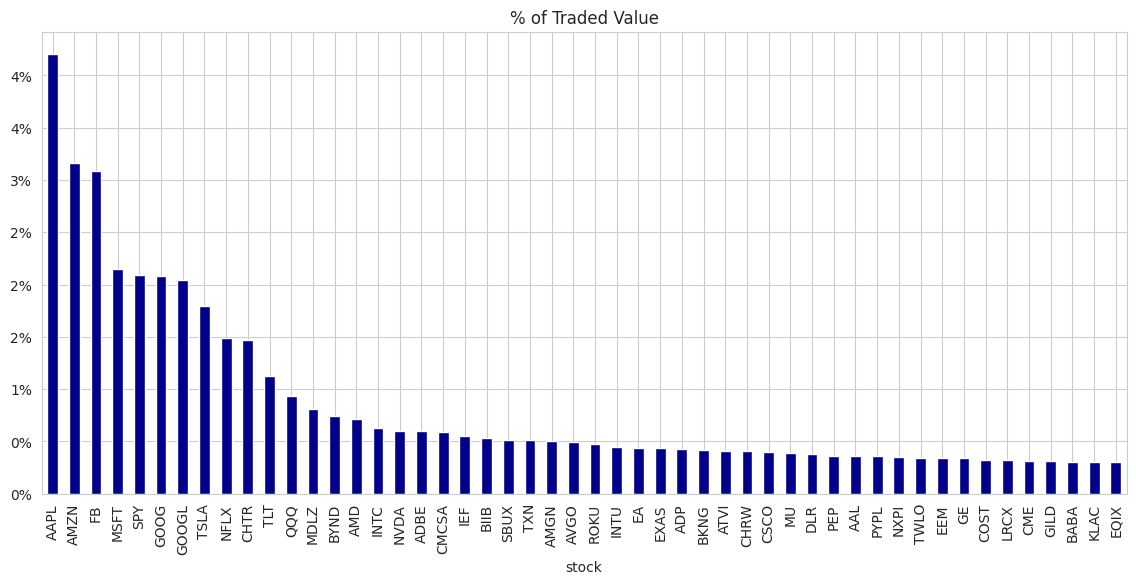

In [7]:
# Load and process trade data
with pd.HDFStore(itch_store) as store:
    # Load stock locate and symbol information
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]

    # Load and combine trade data from 'P' and 'Q' message types
    trades = pd.concat([
        store['P'],
        store['Q'].rename(columns={'cross_price': 'price'})
    ], sort=False).merge(stocks)

# Calculate trade values and value share
trades['value'] = trades.shares.mul(trades.price)
trades['value_share'] = trades.value.div(trades.value.sum())

# Summarize trades by stock
trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)

# Plot top 50 stocks by traded value
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='% of Traded Value')

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [9]:
# AAPL Trade Summary

# Load AAPL trade data
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]

# Process AAPL trade data
trades.price = trades.price.mul(1e-4)  # Convert price to dollars
trades = trades[trades.cross == 0]  # Remove cross trades
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)

# Display information about the AAPL trades dataset
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58715 entries, 2019-10-30 09:30:00.010384780 to 2019-10-30 15:59:59.979015439
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   shares  58715 non-null  int64  
 1   price   58715 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.3 MB


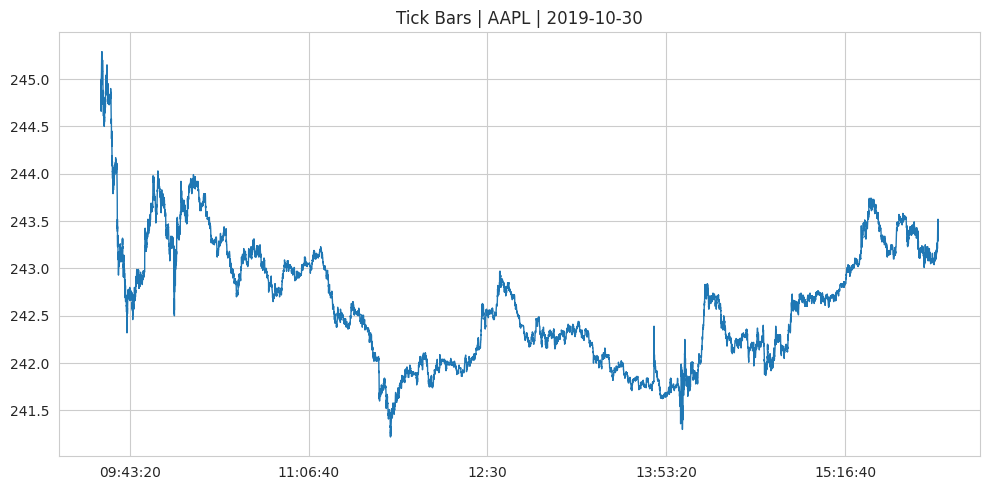

In [11]:
# Tick Bars

# Create tick bars (raw trade data)
tick_bars = trades.copy()
tick_bars.index = tick_bars.index.time

# Plot tick bars
tick_bars.price.plot(figsize=(10, 5),
                     title='Tick Bars | {} | {}'.format(stock, pd.to_datetime(date).date()),
                     lw=1)
plt.xlabel('')
plt.tight_layout()



In [12]:
# Test for Normality of tick returns
normaltest_result = normaltest(tick_bars.price.pct_change().dropna())
print(f"Normality test for tick returns: statistic={normaltest_result.statistic:.4f}, p-value={normaltest_result.pvalue:.4f}")


Normality test for tick returns: statistic=20194.1013, p-value=0.0000


In [13]:
# Regularizing Tick Data

# Function to create price-volume chart
def price_volume(df, price='vwap', vol='vol', suptitle=title, fname=None):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
    axes[0].plot(df.index, df[price])
    axes[1].bar(df.index, df[vol], width=1/(5*len(df.index)), color='r')

    # formatting
    xfmt = mpl.dates.DateFormatter('%H:%M')
    axes[1].xaxis.set_major_locator(mpl.dates.HourLocator(interval=3))
    axes[1].xaxis.set_major_formatter(xfmt)
    axes[1].get_xaxis().set_tick_params(which='major', pad=25)
    axes[0].set_title('Price', fontsize=14)
    axes[1].set_title('Volume', fontsize=14)
    fig.autofmt_xdate()
    fig.suptitle(suptitle)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

In [14]:
# Function to calculate bar statistics
def get_bar_stats(agg_trades):
    vwap = agg_trades.apply(lambda x: np.average(x.price, weights=x.shares)).to_frame('vwap')
    ohlc = agg_trades.price.ohlc()
    vol = agg_trades.shares.sum().to_frame('vol')
    txn = agg_trades.shares.size().to_frame('txn')
    return pd.concat([ohlc, vwap, vol, txn], axis=1)

In [15]:
# Time Bars
resampled = trades.groupby(pd.Grouper(freq='1Min'))
time_bars = get_bar_stats(resampled)
normaltest_result = normaltest(time_bars.vwap.pct_change().dropna())
print(f"Normality test for time bar returns: statistic={normaltest_result.statistic:.4f}, p-value={normaltest_result.pvalue:.4f}")


Normality test for time bar returns: statistic=65.6612, p-value=0.0000


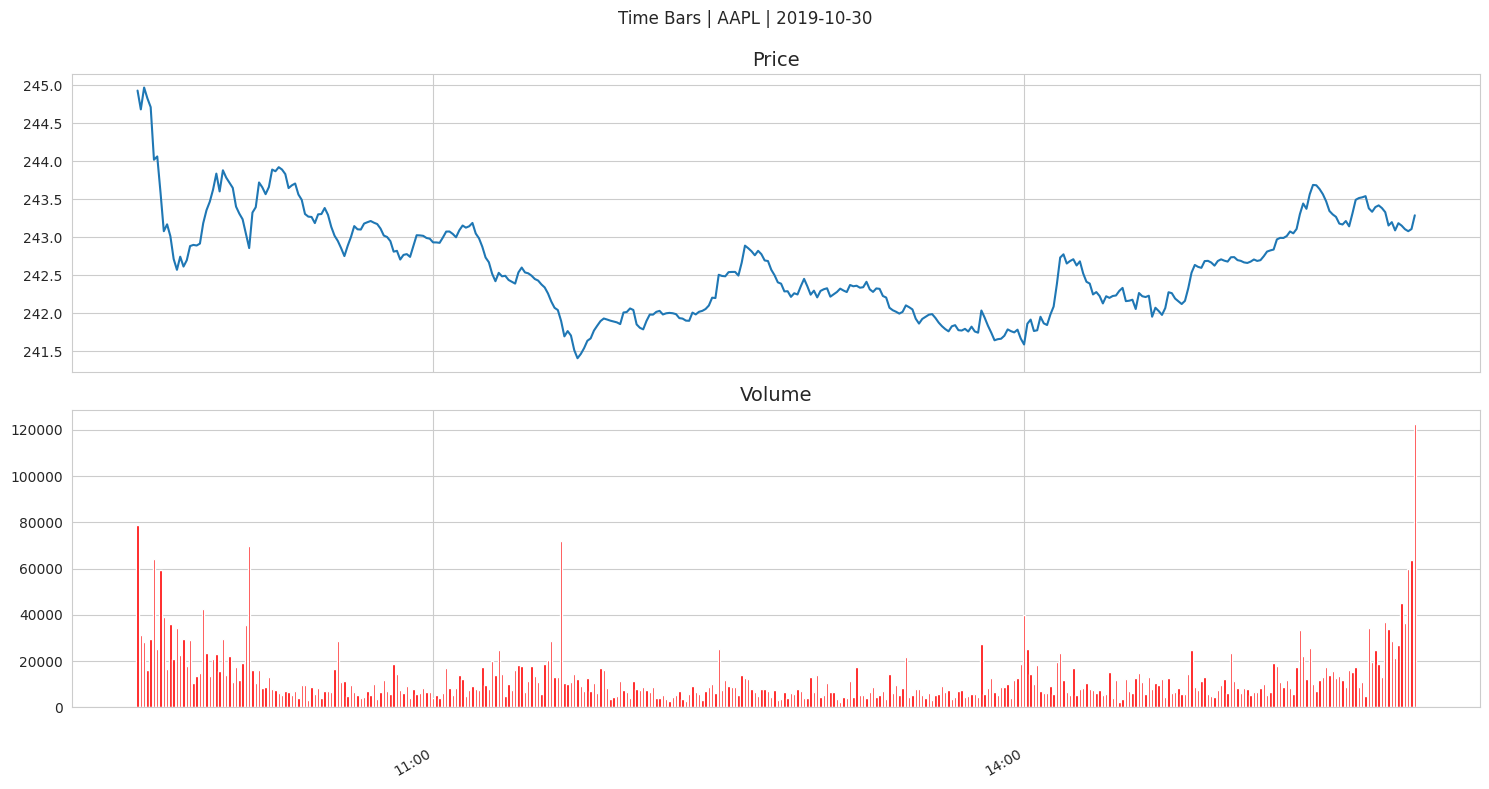

In [16]:
# Plot time bars
price_volume(time_bars,
             suptitle=f'Time Bars | {stock} | {pd.to_datetime(date).date()}',
             fname='time_bars')

In [23]:
!pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.0 MB/s eta 0:00:00



MATPLOTLIB CANDLESTICK CHART (5-MINUTE BARS)
Column names: Index(['Open', 'High', 'Low', 'Close', 'vwap', 'Volume', 'txn'], dtype='object')

First 5 rows of data:
                      Open   High    Low  Close   vwap  Volume   txn
Date                                                                
2019-10-30 09:30:00 244.83 245.29 244.37 244.45 244.85  184300  2016
2019-10-30 09:35:00 244.40 244.40 242.93 243.30 243.65  204273  2563
2019-10-30 09:40:00 243.29 243.29 242.32 242.65 242.74  142736  1712
2019-10-30 09:45:00 242.66 242.99 242.57 242.92 242.85   85716  1005
2019-10-30 09:50:00 242.93 243.98 242.91 243.74 243.45  123816  1584


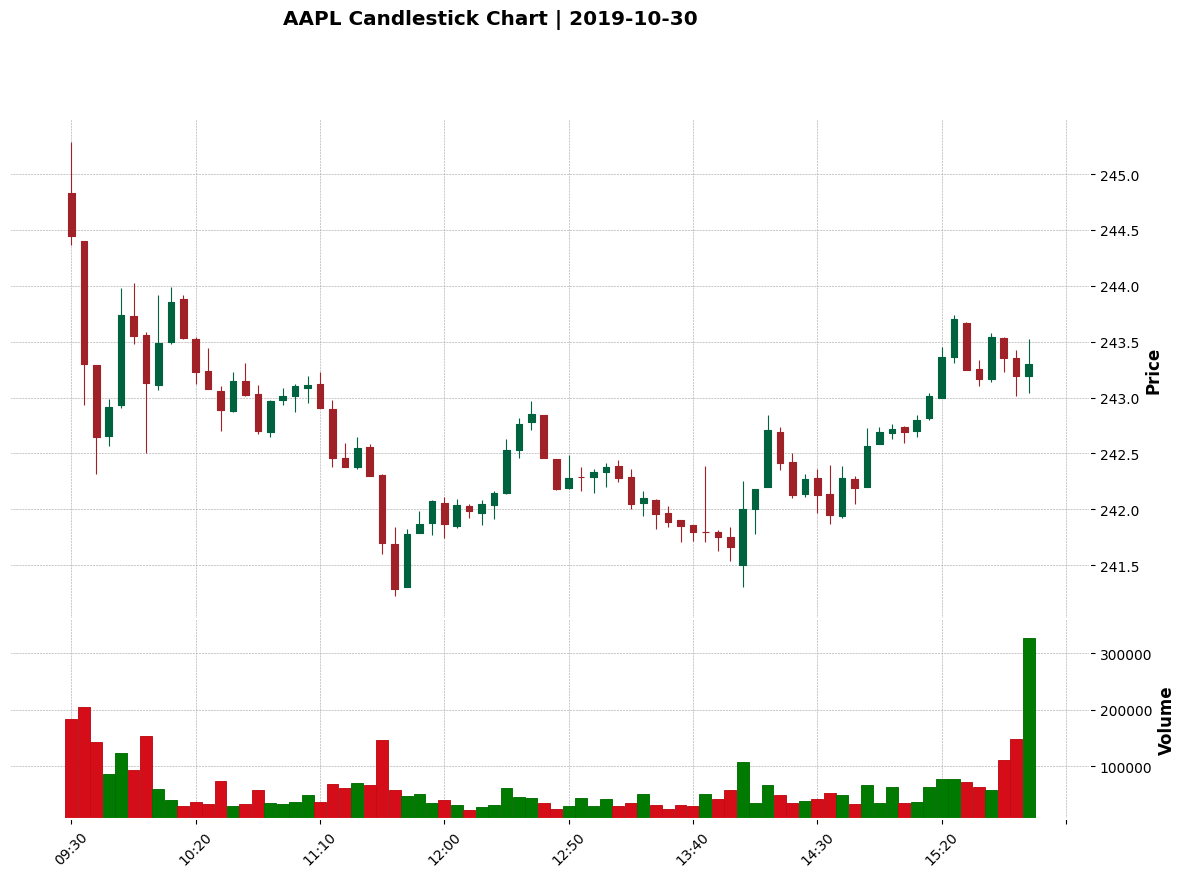


Summary statistics:
        Open   High    Low  Close   vwap    Volume     txn
count  78.00  78.00  78.00  78.00  78.00     78.00   78.00
mean  242.62 242.82 242.41 242.60 242.62  61715.45  752.76
std     0.67   0.70   0.61   0.63   0.64  48088.53  516.83
min   241.30 241.81 241.22 241.29 241.60  21739.00  322.00
25%   242.10 242.32 241.92 242.11 242.06  34749.00  457.25
50%   242.55 242.74 242.36 242.54 242.59  46246.00  573.00
75%   243.08 243.28 242.91 243.10 243.09  66885.75  787.75
max   244.83 245.29 244.37 244.45 244.85 327535.00 3185.00


In [26]:
# Matplotlib Candlestick Chart
print("\n" + "="*50)
print("MATPLOTLIB CANDLESTICK CHART (5-MINUTE BARS)")
print("="*50)

import matplotlib.pyplot as plt
import mplfinance as mpf

# Resample the trade data into 5-minute bars
resampled = trades.groupby(pd.Grouper(freq='5Min'))  # 5 Min bars for better visualization
df = get_bar_stats(resampled)

# Ensure all required columns are present
df = df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'vol': 'Volume'})

# Prepare data for candlestick chart
df = df.reset_index()
df = df.rename(columns={'timestamp': 'Date'})
df = df.set_index('Date')

# Print column names to verify
print("Column names:", df.columns)

# Print first few rows to check data
print("\nFirst 5 rows of data:")
print(df.head())

# Create the candlestick chart
mpf.plot(df, type='candle', style='charles',
         title=f'AAPL Candlestick Chart | {pd.to_datetime(date).date()}',
         ylabel='Price',
         ylabel_lower='Volume',
         volume=True,
         figsize=(15, 10))

# Print some statistics
print("\nSummary statistics:")
print(df.describe())

## AAPL Candlestick Chart Analysis (2019-10-30)

1. **Price Range**: $241.50 - $245.00 approximately
2. **Opening**: High open, indicated by tall red candle at market open (9:30 AM)
3. **Closing**: Slightly lower than open, but above day's low
4. **Intraday Trend**:
   - Morning: Downward trend
   - Midday: Consolidation
   - Afternoon: Gradual upward trend
5. **Volatility**: Higher in morning, lower midday, increased towards close
6. **Volume**:
   - Highest at market open and close
   - Significant spike near end of trading day
7. **Support Level**: Around $241.50-$242.00
8. **Resistance Level**: Around $244.00-$244.50
9. **Market Sentiment**: Mixed (balanced red and green candles)
10. **Time Frame**: Standard trading hours (9:30 AM - 4:00 PM ET)
11. **End-of-Day Activity**: Significant volume increase in last 30 minutes

Key Observations:
- The stock showed resilience, bouncing off support levels multiple times
- Increased end-of-day volume suggests potential important news or heightened interest
- The mixed candle colors indicate a day of balanced bullish and bearish sentiment


VOLUME BARS
Number of volume bars: 451
Average shares per bar: 10673.63


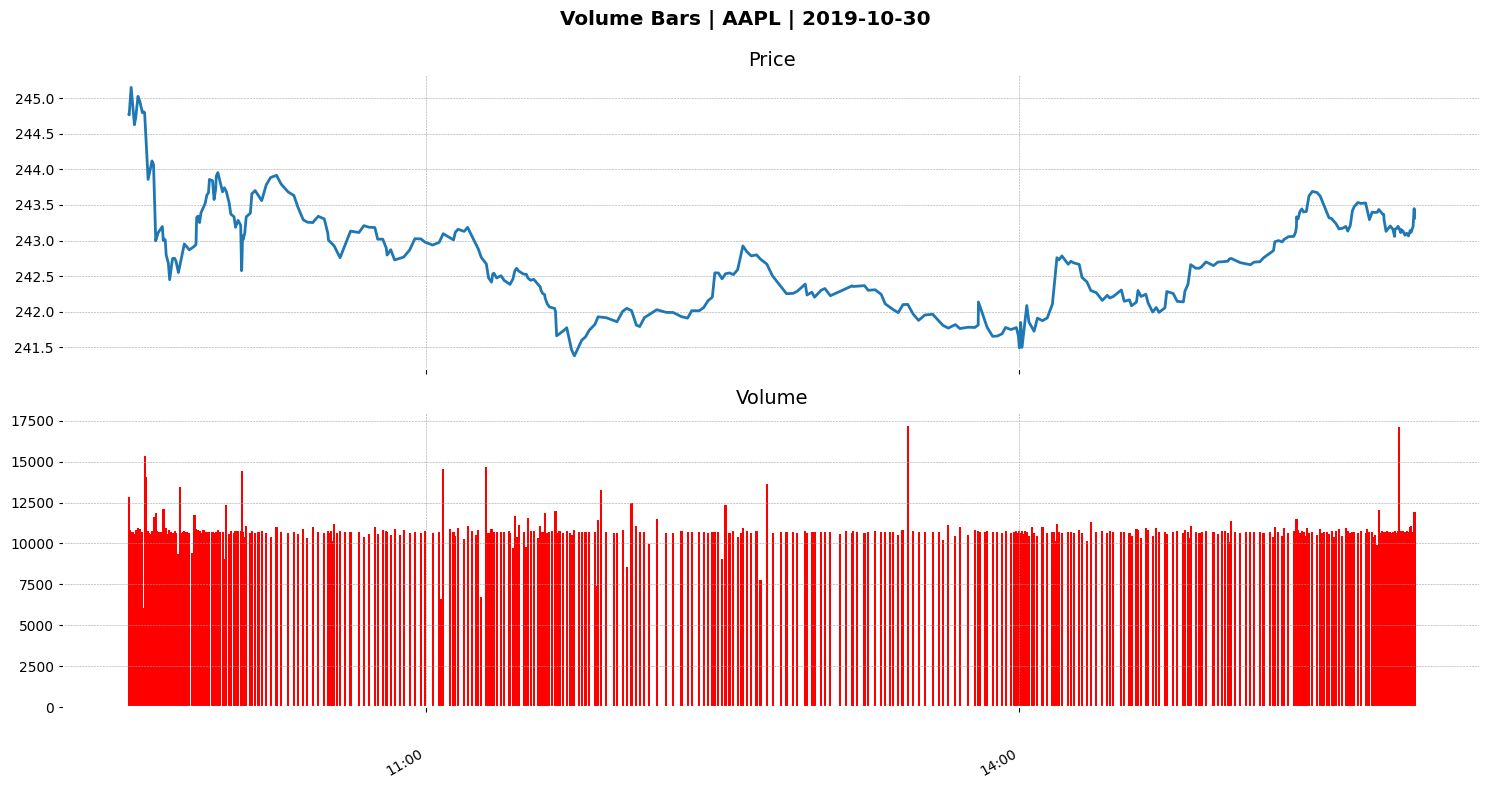


Normality test for volume bar returns:
Statistic: 13.3807
P-value: 0.0012

Volume Bar Statistics:
        open   high    low  close   vwap      vol    txn
count 451.00 451.00 451.00 451.00 451.00   451.00 451.00
mean  242.82 242.90 242.75 242.82 242.82 10673.63 130.19
std     0.74   0.74   0.73   0.74   0.74  1070.24  32.87
min   241.37 241.50 241.22 241.37 241.38  3190.00  16.00
25%   242.26 242.35 242.17 242.26 242.25 10638.00 111.00
50%   242.80 242.89 242.74 242.80 242.80 10699.00 134.00
75%   243.24 243.32 243.17 243.23 243.24 10759.50 151.50
max   245.19 245.29 245.06 245.20 245.15 17163.00 232.00

Average time between volume bars: 0 days 00:00:51.998385121


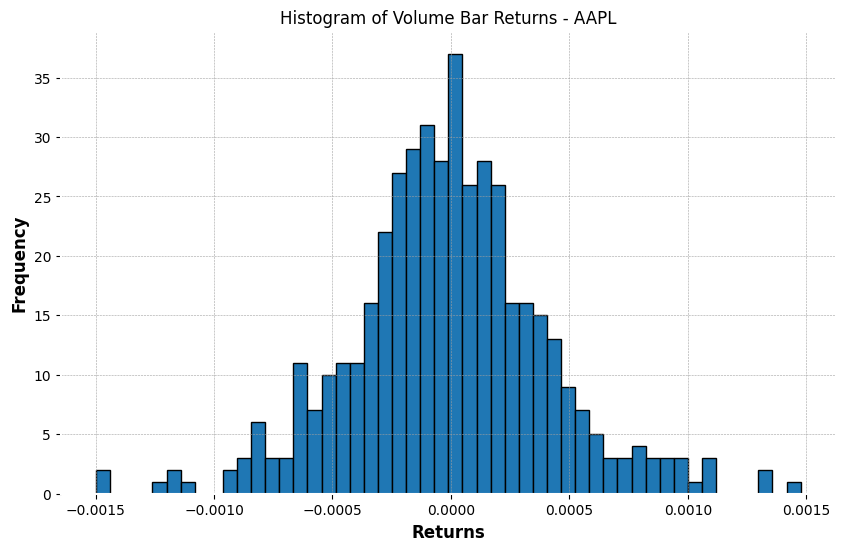

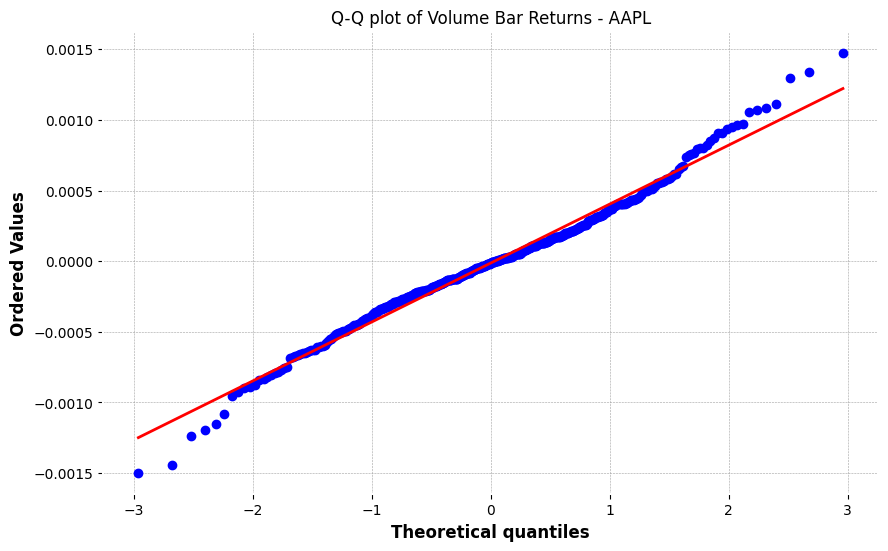

In [27]:
# Volume Bars
print("\n" + "="*50)
print("VOLUME BARS")
print("="*50)

# Calculate the average number of shares traded per minute
trades_per_min = trades.shares.sum() / (60 * 7.5)  # 7.5 hours in a trading day

# Compute cumulative volume
trades['cumul_vol'] = trades.shares.cumsum()

# Create volume bars
df = trades.reset_index()
by_vol = df.groupby(df.cumul_vol.div(trades_per_min).round().astype(int))
vol_bars = pd.concat([by_vol.timestamp.last().to_frame('timestamp'), get_bar_stats(by_vol)], axis=1)

# Set the timestamp as index
vol_bars = vol_bars.set_index('timestamp')

# Print basic information about the volume bars
print(f"Number of volume bars: {len(vol_bars)}")
print(f"Average shares per bar: {vol_bars.vol.mean():.2f}")

# Plot volume bars
price_volume(vol_bars,
             suptitle=f'Volume Bars | {stock} | {pd.to_datetime(date).date()}',
             fname='volume_bars')
plt.show()

# Perform normality test on volume bar returns
vwap_returns = vol_bars.vwap.pct_change().dropna()
normaltest_result = normaltest(vwap_returns)
print(f"\nNormality test for volume bar returns:")
print(f"Statistic: {normaltest_result.statistic:.4f}")
print(f"P-value: {normaltest_result.pvalue:.4f}")

# Additional analysis
print("\nVolume Bar Statistics:")
print(vol_bars.describe())

# Calculate and print the average time between volume bars
time_diff = vol_bars.index.to_series().diff().mean()
print(f"\nAverage time between volume bars: {time_diff}")

# Plot histogram of returns
plt.figure(figsize=(10, 6))
plt.hist(vwap_returns, bins=50, edgecolor='black')
plt.title(f'Histogram of Volume Bar Returns - {stock}')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

# Plot QQ plot of returns
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(vwap_returns, dist="norm", plot=plt)
plt.title(f"Q-Q plot of Volume Bar Returns - {stock}")
plt.show()


DOLLAR BARS
Number of dollar bars: 451
Average dollar volume per bar: $2591768.33


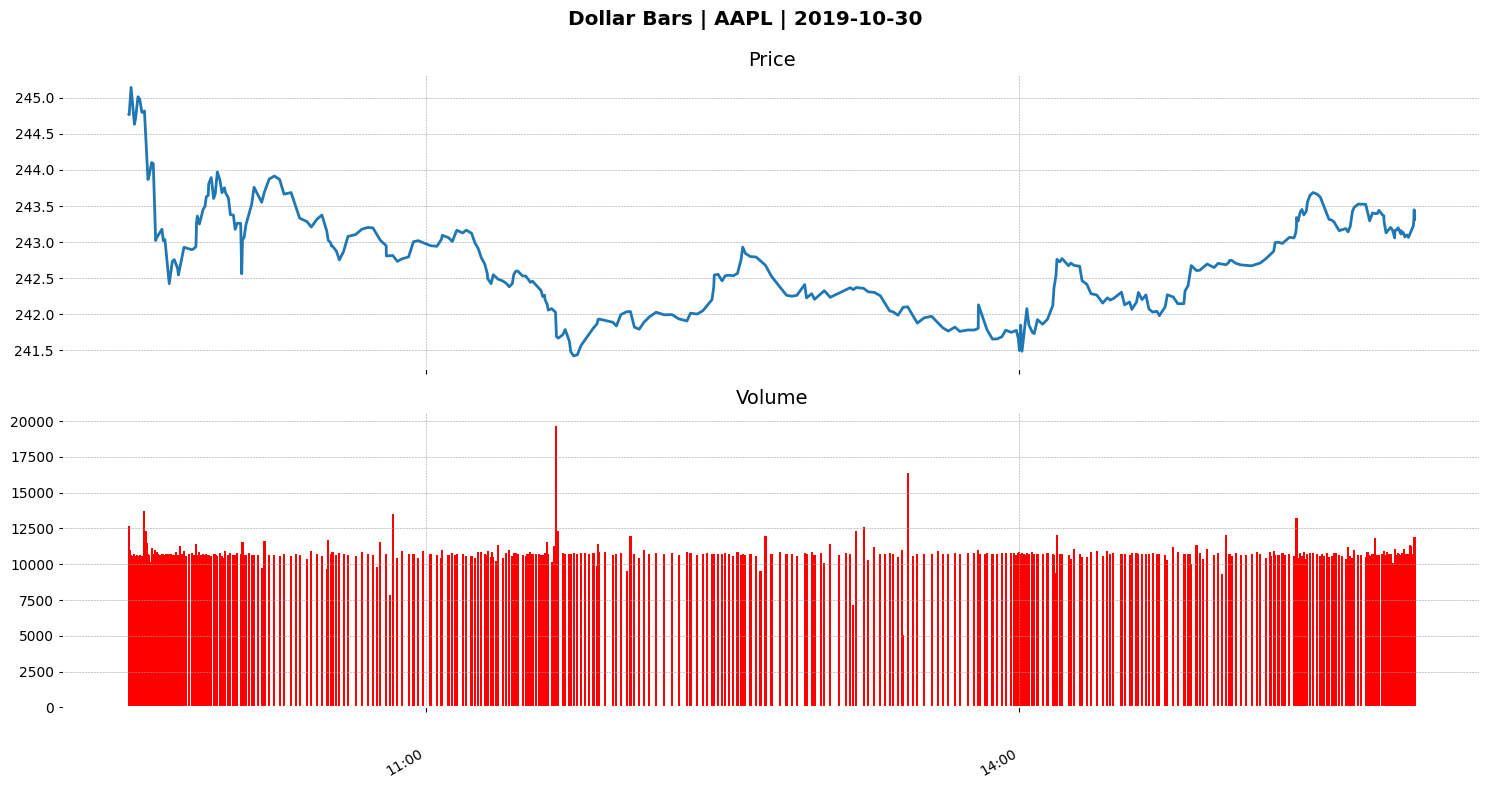


Normality test for dollar bar returns:
Statistic: 11.8933
P-value: 0.0026

Dollar Bar Statistics:
        open   high    low  close   vwap      vol    txn
count 451.00 451.00 451.00 451.00 451.00   451.00 451.00
mean  242.83 242.90 242.75 242.82 242.82 10673.63 130.19
std     0.74   0.74   0.74   0.74   0.74   947.18  32.71
min   241.24 241.51 241.22 241.23 241.42  3190.00  16.00
25%   242.25 242.35 242.17 242.25 242.26 10619.50 112.00
50%   242.84 242.90 242.72 242.84 242.81 10703.00 134.00
75%   243.26 243.32 243.19 243.25 243.23 10778.50 150.50
max   245.16 245.29 245.06 245.17 245.14 19650.00 225.00

Average time between dollar bars: 0 days 00:00:51.998385121


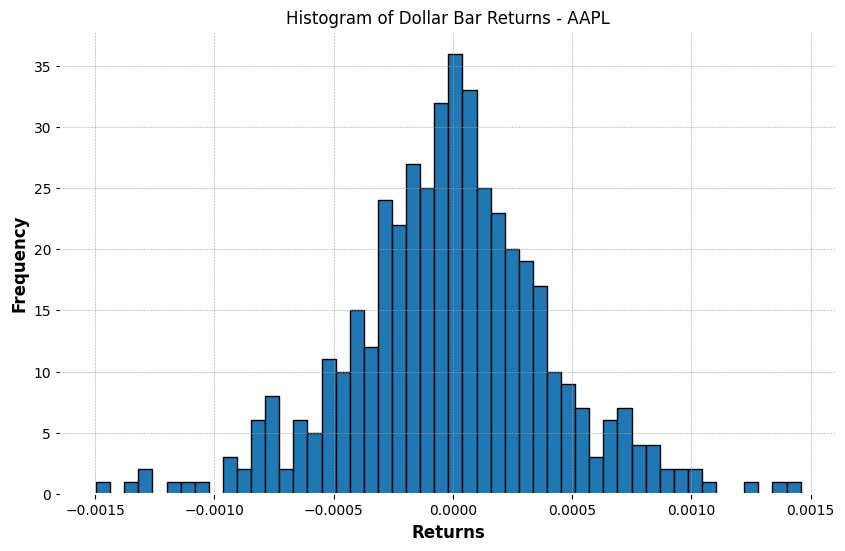

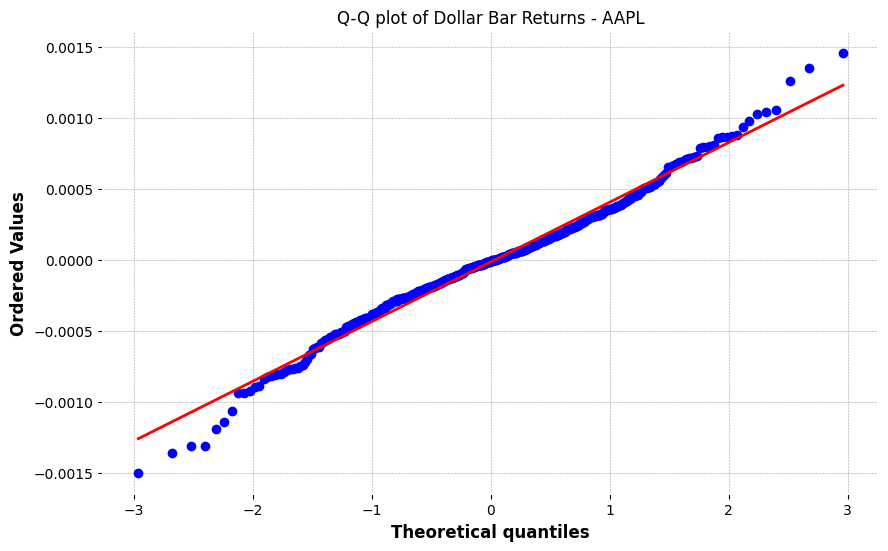


Dollar Bar Returns Statistics:
Mean: -0.000013
Standard Deviation: 0.000421
Skewness: -0.054354
Kurtosis: 1.090433


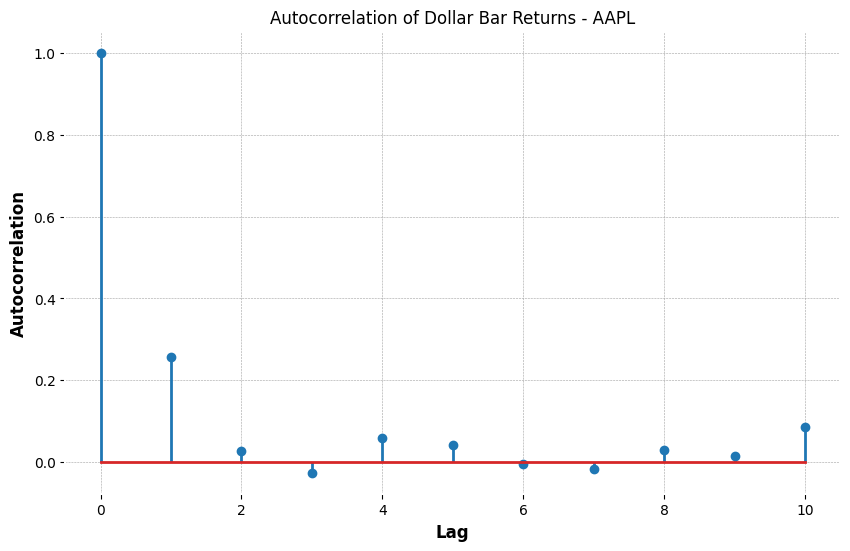

In [28]:
# Dollar Bars
print("\n" + "="*50)
print("DOLLAR BARS")
print("="*50)

# Calculate the average dollar volume per minute
value_per_min = trades.shares.mul(trades.price).sum() / (60 * 7.5)  # 7.5 hours in a trading day

# Compute cumulative dollar volume
trades['cumul_val'] = trades.shares.mul(trades.price).cumsum()

# Create dollar bars
df = trades.reset_index()
by_value = df.groupby(df.cumul_val.div(value_per_min).round().astype(int))
dollar_bars = pd.concat([by_value.timestamp.last().to_frame('timestamp'), get_bar_stats(by_value)], axis=1)

# Set the timestamp as index
dollar_bars = dollar_bars.set_index('timestamp')

# Print basic information about the dollar bars
print(f"Number of dollar bars: {len(dollar_bars)}")
print(f"Average dollar volume per bar: ${dollar_bars.vol.mul(dollar_bars.vwap).mean():.2f}")

# Plot dollar bars
price_volume(dollar_bars,
             suptitle=f'Dollar Bars | {stock} | {pd.to_datetime(date).date()}',
             fname='dollar_bars')
plt.show()

# Perform normality test on dollar bar returns
vwap_returns = dollar_bars.vwap.pct_change().dropna()
normaltest_result = normaltest(vwap_returns)
print(f"\nNormality test for dollar bar returns:")
print(f"Statistic: {normaltest_result.statistic:.4f}")
print(f"P-value: {normaltest_result.pvalue:.4f}")

# Additional analysis
print("\nDollar Bar Statistics:")
print(dollar_bars.describe())

# Calculate and print the average time between dollar bars
time_diff = dollar_bars.index.to_series().diff().mean()
print(f"\nAverage time between dollar bars: {time_diff}")

# Plot histogram of returns
plt.figure(figsize=(10, 6))
plt.hist(vwap_returns, bins=50, edgecolor='black')
plt.title(f'Histogram of Dollar Bar Returns - {stock}')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

# Plot QQ plot of returns
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(vwap_returns, dist="norm", plot=plt)
plt.title(f"Q-Q plot of Dollar Bar Returns - {stock}")
plt.show()

# Compare dollar bar returns to normal distribution
from scipy.stats import kurtosis, skew

print("\nDollar Bar Returns Statistics:")
print(f"Mean: {vwap_returns.mean():.6f}")
print(f"Standard Deviation: {vwap_returns.std():.6f}")
print(f"Skewness: {skew(vwap_returns):.6f}")
print(f"Kurtosis: {kurtosis(vwap_returns):.6f}")

# Calculate autocorrelation of returns
from statsmodels.tsa.stattools import acf

lag_acf = acf(vwap_returns, nlags=10)
plt.figure(figsize=(10, 6))
plt.stem(range(len(lag_acf)), lag_acf)
plt.title(f'Autocorrelation of Dollar Bar Returns - {stock}')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

## Analysis of AAPL Dollar Bar Charts (2019-10-30)

### 1. Dollar Bars Chart

- **Price Range**: $241.50 - $245.00 approximately
- **Price Trend**:
  - Initial drop from opening high
  - Midday consolidation around $242-$243
  - Late day rally back to $243-$244 range
- **Volume**:
  - Consistent throughout the day with periodic spikes
  - Major volume spikes at ~11:00 AM and ~2:00 PM
  - Higher volume at market open and close

### 2. Histogram of Dollar Bar Returns

- **Distribution Shape**: Approximately bell-shaped, suggesting near-normal distribution
- **Symmetry**: Slightly right-skewed (positive skew)
- **Concentration**: Most returns clustered around 0, indicating small price movements between bars
- **Tails**: Presence of some extreme returns, but relatively few

### 3. Q-Q Plot of Dollar Bar Returns

- **Fit to Normal**: Generally good fit along the diagonal line
- **Deviations**:
  - Slight S-shape indicates heavier tails than a normal distribution
  - Lower tail shows more extreme negative returns than expected
  - Upper tail shows more extreme positive returns than expected

### 4. Autocorrelation of Dollar Bar Returns

- **Lag 0**: Perfect correlation of 1.0 (expected)
- **Lag 1**: Significant positive autocorrelation (~0.25)
- **Other Lags**: Minimal autocorrelation, mostly within noise levels

### Key Observations:
1. Dollar bar returns are approximately normally distributed but with slightly fatter tails.
2. There's a notable short-term (lag 1) positive autocorrelation in returns, suggesting some predictability.
3. The price action shows a typical U-shaped pattern with higher volatility at open and close.
4. Volume distribution aligns with price volatility, showing increased activity at market open and close.